## SENG 474 Project : Sarcasm detection using text classification

In [34]:
import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

import plotly
import plotly.graph_objects as go

from nltk.corpus import wordnet
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


## Below code is used to plot confusion matrices, will be used throughout the report 

In [3]:

## Code modified from 
## https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Read in our json file into a dataframe

In [4]:
##read in json into dataframe
with open('Sarcasm_Headlines_Dataset_v2.json', encoding = "utf8") as file:
    data = file.readlines()
data = map(lambda x: x.rstrip(), data)
data_json = "[" + ",".join(data) +"]"
    
data_frame = pd.read_json(data_json)
data_frame.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


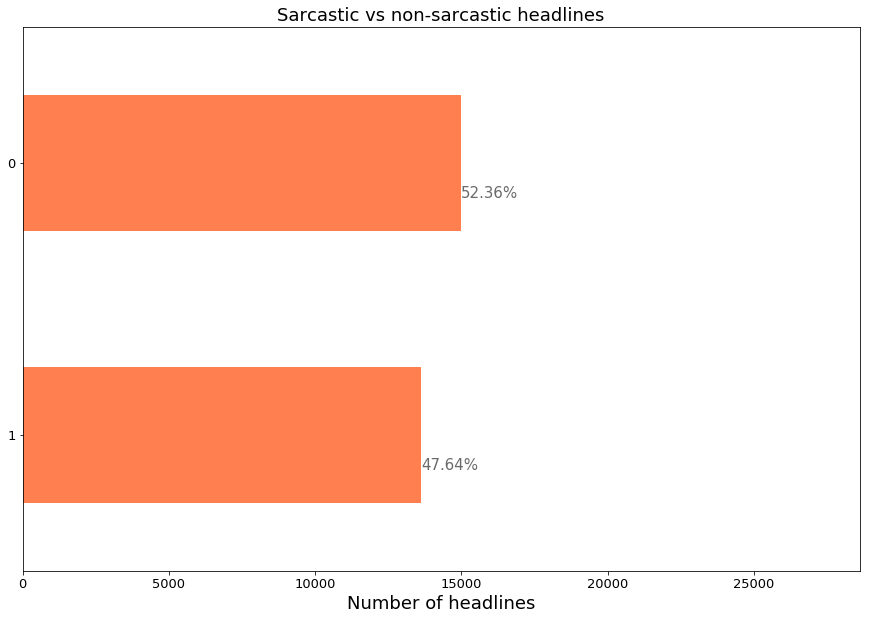

In [6]:
ax = data_frame['is_sarcastic'].value_counts().plot(kind='barh', figsize=(15,10),
                                        color="coral", fontsize=13);
ax.set_title("Sarcastic vs non-sarcastic headlines", fontsize=18)
ax.set_xlabel("Number of headlines", fontsize=18);
ax.set_xlim(0, len(data_frame['is_sarcastic'].values))
total = len(data_frame['is_sarcastic'].values)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='dimgrey')

ax.invert_yaxis()

Thats pretty balanced, show word clouds for sarcastic/non-sarcastic and all below

## word cloud showing most common words in all headlines

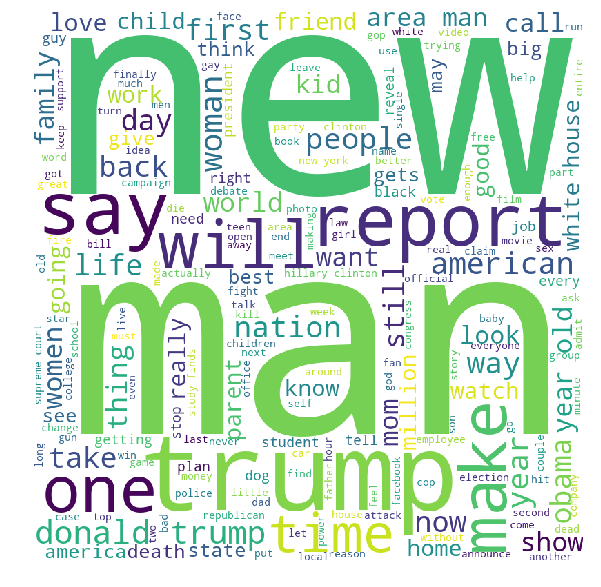

In [111]:
## all articles headlines
comment_words = ' '
stopwords = set(STOPWORDS) 
 
for val in data_frame['headline']: 
    #print(val)  
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '    

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
    
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Word cloud showing most common words for sarcastic headlines

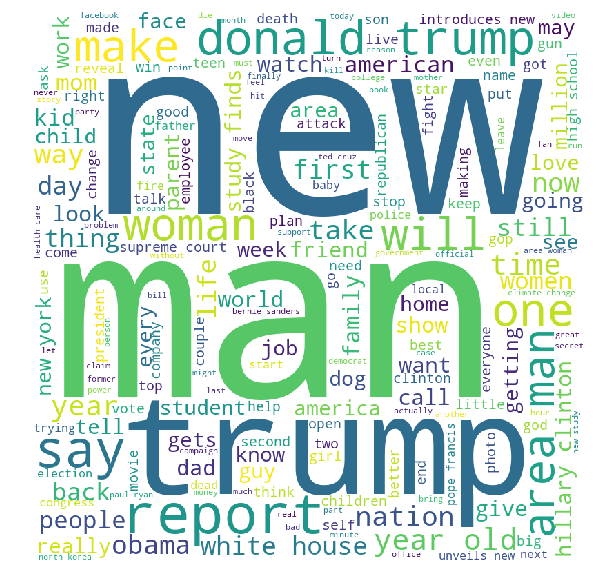

In [116]:
#sarcastic article headlines
#code modified from https://www.geeksforgeeks.org/generating-word-cloud-python/

for i, val in enumerate(data_frame[data_frame['is_sarcastic'] == 1]['headline'].values): 

        #print(val)  
        # typecaste each val to string 
    val = str(val) 

        # split the value 
    tokens = val.split() 

        # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 

    for words in tokens: 
        comment_words = comment_words + words + ' ' 
            
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
    
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Word cloud showing most common words in non-sarcastic headlines

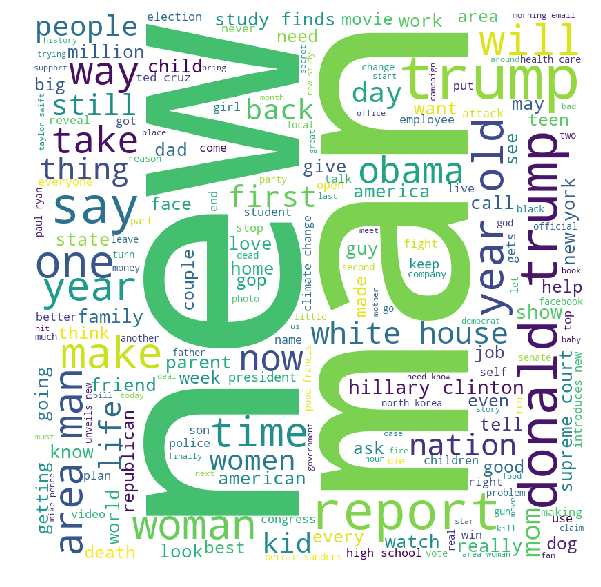

In [117]:
#sarcastic article headlines
#code modified from https://www.geeksforgeeks.org/generating-word-cloud-python/

for i, val in enumerate(data_frame[data_frame['is_sarcastic'] == 0]['headline'].values): 

    val = str(val) 
    tokens = val.split()  
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 

    for words in tokens: 
        comment_words = comment_words + words + ' ' 
            
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
    
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Read in our article content into a dataframe, could probably talk more about this and how we scraped the webpages

In [7]:
## open and store article content

with open('article_content.json') as json_file:
    data_article_content = json.load(json_file)
    


## Split our set into a training and testing set, graph ratio of sarcastic/non-sarcastic entries in each set

Number of rows in training set:  21464
Number of rows in testing set:  7155


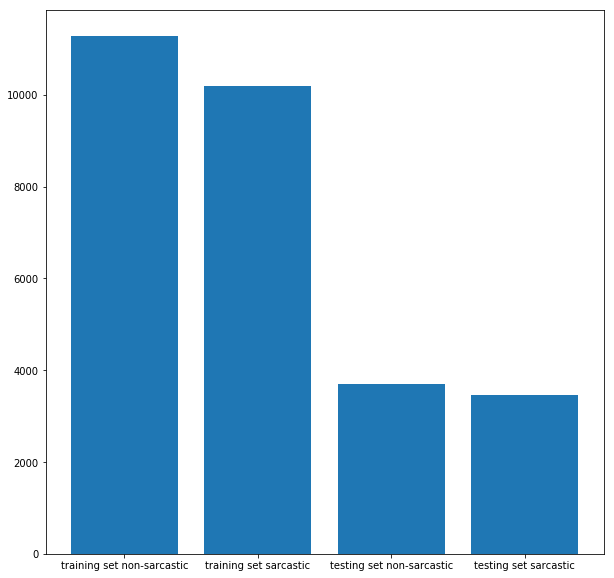

In [49]:

X_train, X_test, y_train, y_test = train_test_split(
    data_frame['headline'], 
    data_frame['is_sarcastic'], 
    random_state = 1
)

print("Number of rows in training set: ", X_train.shape[0])
print("Number of rows in testing set: ", X_test.shape[0])


train_set_non_sarcatic_count = y_train[y_train == 0]
test_set_sarcastic_count = y_test[y_test == 1]
test_set_non_sarcastic_count = y_test[y_test == 0]       
train_set_sarcastic = y_train[y_train == 1]

height = [len(train_set_non_sarcatic_count), len(train_set_sarcastic), len(test_set_non_sarcastic_count), 
          len(test_set_sarcastic_count)]
bars = ('training set non-sarcastic', 'training set sarcastic', 'testing set non-sarcastic', 'testing set sarcastic')
y_pos = np.arange(len(bars))
plt.figure(figsize=(10, 10))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()



## 1st experiment training/testing on a normal naive bayes with only stop word removal

In [50]:
count_vector = CountVectorizer(stop_words = 'english')
training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)

In [51]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)
predictions = naive_bayes.predict(testing_data)

In [52]:

h_accuracy = accuracy_score(y_test, predictions)
h_recall = recall_score(y_test, predictions, average = 'weighted')
h_precision = precision_score(y_test, predictions, average = 'weighted')
h_f1 = f1_score(y_test, predictions, average = 'weighted')

print("Accuracy score: ", h_accuracy)
print("Recall score: ",h_recall)
print("Precision score: ", h_precision)
print("F1 score: ", h_f1)

Accuracy score:  0.7997204751921733
Recall score:  0.7997204751921733
Precision score:  0.7996792454964032
F1 score:  0.799680701367876


## results for first experiment, confusion matrix , maybe should add more visualization

Confusion matrix, without normalization
[[3006  699]
 [ 734 2716]]
Normalized confusion matrix
[[0.81133603 0.18866397]
 [0.21275362 0.78724638]]


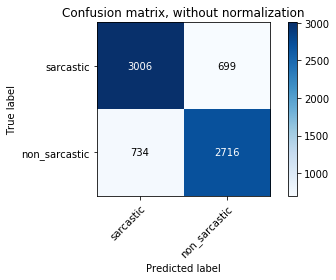

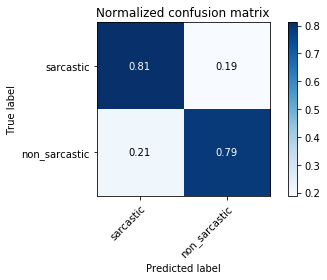

In [53]:
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=False)
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=True)

maybe add SVM experiment on set from above

## 2nd experiment, add lemmatization to the article headlines

In [10]:
##lemmatization for headlines

def get_wordnet_pos(wordnet_tag):

    if wordnet_tag.startswith('J'):
        return wordnet.ADJ
    elif wordnet_tag.startswith('V'):
        return wordnet.VERB
    elif wordnet_tag.startswith('N'):
        return wordnet.NOUN
    elif wordnet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN



data_frame['headline'] = [text.lower() for text in data_frame['headline']]
data_frame['headline'] = [nltk.tokenize.word_tokenize(text) for text in data_frame['headline']]

for i, entry in enumerate(data_frame['headline']):
    tokenized_words = []
    lem = nltk.stem.WordNetLemmatizer()
    for word, tag in nltk.pos_tag(entry):
        if word not in nltk.corpus.stopwords.words('english') and word.isalpha():
            tokenized_words.append(lem.lemmatize(word,get_wordnet_pos(tag[0])))
    data_frame.loc[i, 'tokenized_headline'] = str(tokenized_words)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data_frame['tokenized_headline'], 
    data_frame['is_sarcastic'], 
    random_state = 1
)

In [15]:
count_vector = CountVectorizer()
training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)
predictions = naive_bayes.predict(testing_data)

## score and confusion matrix for lemmatization experiment 

In [16]:
### Scores for article headlines ###
h_accuracy = accuracy_score(y_test, predictions)
h_recall = recall_score(y_test, predictions, average = 'weighted')
h_precision = precision_score(y_test, predictions, average = 'weighted')
h_f1 = f1_score(y_test, predictions, average = 'weighted')

print("Accuracy score: ", h_accuracy)
print("Recall score: ",h_recall)
print("Precision score: ", h_precision)
print("F1 score: ", h_f1)

Accuracy score:  0.7847658979734451
Recall score:  0.7847658979734451
Precision score:  0.7847251150705072
F1 score:  0.7847351340415168


Confusion matrix, without normalization
[[2948  757]
 [ 783 2667]]
Normalized confusion matrix
[[0.79568151 0.20431849]
 [0.22695652 0.77304348]]


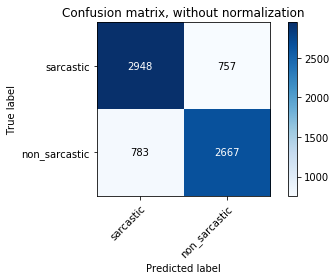

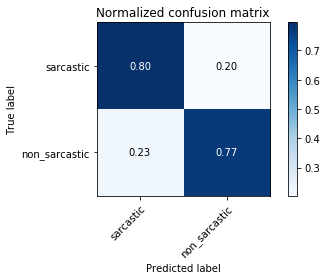

In [17]:
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=False)
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=True)

## 3rd experiment, trying a different vectorization method TFIDF, maybe do this for all the other experiments

In [25]:
## try out a different vectorizer, TFIDF

X_train, X_test, y_train, y_test = train_test_split(
    data_frame['tokenized_headline'], 
    data_frame['is_sarcastic'], 
    random_state = 1
)

Tfidf_vect = TfidfVectorizer()
Train_X_Tfidf = Tfidf_vect.fit_transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [26]:
naive_bayes = MultinomialNB()
naive_bayes.fit(Train_X_Tfidf, y_train)
predictions = naive_bayes.predict(Test_X_Tfidf)

## results for TFIDF experiment 

Accuracy score:  0.7842068483577918
Recall score:  0.7842068483577918
Precision score:  0.7856967273790199
F1 score:  0.7834639231667319
Confusion matrix, without normalization
[[3088  617]
 [ 927 2523]]
Normalized confusion matrix
[[0.83346829 0.16653171]
 [0.26869565 0.73130435]]


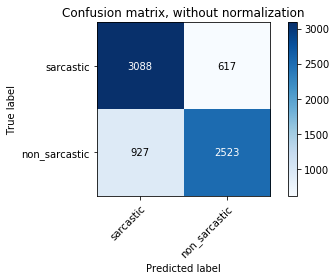

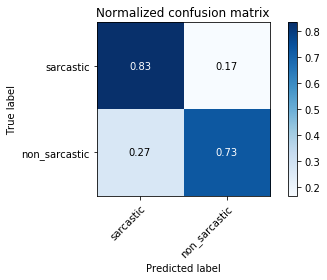

In [28]:
h_accuracy = accuracy_score(y_test, predictions)
h_recall = recall_score(y_test, predictions, average = 'weighted')
h_precision = precision_score(y_test, predictions, average = 'weighted')
h_f1 = f1_score(y_test, predictions, average = 'weighted')

print("Accuracy score: ", h_accuracy)
print("Recall score: ",h_recall)
print("Precision score: ", h_precision)
print("F1 score: ", h_f1)

plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=False)
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=True)

## 4th experiment, trying out SVC on article headlines

[1 0 1 ... 0 1 1]
Accuracy score:  0.7816911250873515
Recall score:  0.7816911250873515
Precision score:  0.7818030486380065
F1 score:  0.7814636851864676
Confusion matrix, without normalization
[[2992  713]
 [ 849 2601]]
Normalized confusion matrix
[[0.80755735 0.19244265]
 [0.24608696 0.75391304]]


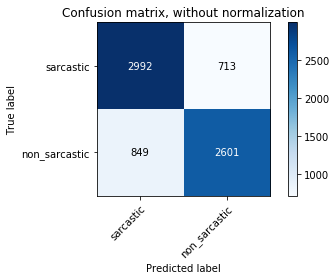

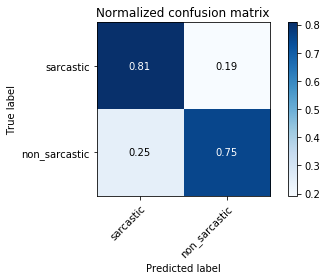

In [31]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(Train_X_Tfidf, y_train)
predictions = svm.predict(Test_X_Tfidf)
print(predictions)

h_accuracy = accuracy_score(y_test, predictions)
h_recall = recall_score(y_test, predictions, average = 'weighted')
h_precision = precision_score(y_test, predictions, average = 'weighted')
h_f1 = f1_score(y_test, predictions, average = 'weighted')

print("Accuracy score: ", h_accuracy)
print("Recall score: ",h_recall)
print("Precision score: ", h_precision)
print("F1 score: ", h_f1)

plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=False)
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=True)

## using Grid Search to fing optimal model for the article headlines (naive bayes), should do SVM too

In [16]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1,3)],'tfidf__use_idf': (True, False),'clf__alpha': (1e-2, 1e-3)}
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

/home/guillaume/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



In [17]:
gs_clf.best_score_
#gs_clf.best_params_

0.775624301155423

## Now doing experiments using full article content as the features

In [8]:
##new dataframe using full text as features 

counter = 0
non_empty_articles_y = []
non_empty_article_content = []
for index, row in data_frame.iterrows():
    if row['article_link'] == data_article_content[str(counter)]['link']:
        non_empty_articles_y.append(row['is_sarcastic'])
        non_empty_article_content.append(data_article_content[str(counter)]['content'])
        counter += 1
        
new_data_frame = pd.DataFrame()
new_data_frame['article_content'] = non_empty_article_content
new_data_frame['labels'] = non_empty_articles_y

new_data_frame.head()

,article_content,labels
0,Vegetables don't have to be boring or relegate...,0
1,"PROVIDENCE, RI—In spite of his best efforts to...",1
2,"PATERSON, NJ—Family sources told reporters Tue...",1
3,To what extent do you own your inheritance?\n\...,0
4,"Even with years of experience, the process of ...",0


## full lemming of the article content

In [37]:
##full lemming and removing stop words

def get_wordnet_pos(wordnet_tag):

    if wordnet_tag.startswith('J'):
        return wordnet.ADJ
    elif wordnet_tag.startswith('V'):
        return wordnet.VERB
    elif wordnet_tag.startswith('N'):
        return wordnet.NOUN
    elif wordnet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN



new_data_frame['article_content'] = [text.lower() for text in new_data_frame['article_content']]
new_data_frame['article_content'] = [nltk.tokenize.word_tokenize(text) for text in new_data_frame['article_content']]

for i, entry in enumerate(new_data_frame['article_content']):
    tokenized_words = []
    lem = nltk.stem.WordNetLemmatizer()
    for word, tag in nltk.pos_tag(entry):
        if word not in nltk.corpus.stopwords.words('english') and word.isalpha():
            tokenized_words.append(lem.lemmatize(word,get_wordnet_pos(tag[0])))
    new_data_frame.loc[i, 'tokenized_text'] = str(tokenized_words)
        
    
    

## splitting article content set into test/training

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    new_data_frame['tokenized_text'], 
    new_data_frame['labels'], 
    random_state = 1
)

## splitting again, this time dont use lemming

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    new_data_frame['article_content'], 
    new_data_frame['labels'], 
    random_state = 1
)

In [21]:
count_vector = CountVectorizer(stop_words = 'english')
training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

predictions

array([0, 0, 0, ..., 1, 0, 1])

## results from article content classification

Confusion matrix, without normalization
[[1821  178]
 [ 146 2628]]
Normalized confusion matrix
[[0.91095548 0.08904452]
 [0.05263158 0.94736842]]


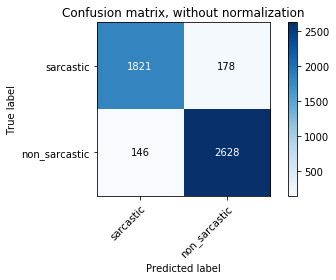

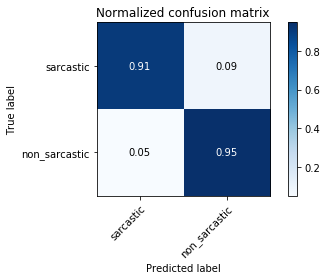

In [22]:
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=False)
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=True)

In [20]:
## content accuracy ##

c_accuracy = accuracy_score(y_test, predictions)
c_recall = recall_score(y_test, predictions, average = 'weighted')
c_precision = precision_score(y_test, predictions, average = 'weighted')
c_f1 = f1_score(y_test, predictions, average = 'weighted')



print("Accuracy score: ", c_accuracy)
print("Recall score: ",c_recall)
print("Precision score: ", c_precision)
print("F1 score: ", c_f1)

Accuracy score:  0.9321181646763043
Recall score:  0.9321181646763043
Precision score:  0.9320458297100551
F1 score:  0.9320389528219852


## Testing out Grid Search for finding best model on tokenized/lemmatized article content (Multinomial Naive Bayes)

In [39]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1,3)],'tfidf__use_idf': (True, False),'clf__alpha': (1e-2, 1e-3)}
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

/home/guillaume/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



## Best parameters are no IDF, 0.01 alpha value, use tri-grams, slightly better accuracy with non-lemmatized article content, will build the actual models to see tradeoffs of lemmatized vs non lemmatized 

In [41]:
gs_clf.best_score_
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 3)}

## trying to implement the above model for naive bayes


In [29]:
transf = TfidfTransformer(use_idf = False)
X_train, X_test, y_train, y_test = train_test_split(
    new_data_frame['article_content'], 
    new_data_frame['labels'], 
    random_state = 1
)


count_vector = CountVectorizer(stop_words = 'english', ngram_range = (1,3))
training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)
training_data = transf.fit_transform(training_data)
testing_data = transf.fit_transform(testing_data)

naive_bayes = MultinomialNB(alpha = 0.01)
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

In [30]:
c_accuracy = accuracy_score(y_test, predictions)
c_recall = recall_score(y_test, predictions, average = 'weighted')
c_precision = precision_score(y_test, predictions, average = 'weighted')
c_f1 = f1_score(y_test, predictions, average = 'weighted')



print("Accuracy score: ", c_accuracy)
print("Recall score: ",c_recall)
print("Precision score: ", c_precision)
print("F1 score: ", c_f1)

Accuracy score:  0.9708778545987848
Recall score:  0.9708778545987848
Precision score:  0.9709692961258425
F1 score:  0.9709005272698346


Confusion matrix, without normalization
[[1965   34]
 [  65 2709]]
Normalized confusion matrix
[[0.9829915  0.0170085 ]
 [0.02343187 0.97656813]]


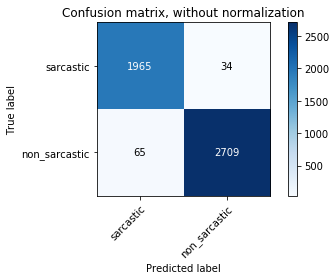

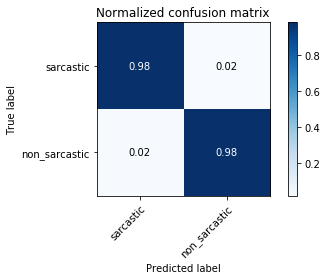

In [36]:
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=False)
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=True)

## Testing out Grid Search for finding best model on tokenized/lemmatized article content (SVM)

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1,3)],'tfidf__use_idf': (True, False),'clf-svm__alpha': (1e-2, 1e-3)}
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf-svm', SGDClassifier())])
#text_clf_ = text_clf_svm.fit(X_train, y_train)

gs_clf = GridSearchCV(text_clf_svm, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

/home/guillaume/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

/home/guillaume/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning:

max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.



## Best parameters are no IDF, 0.001 alpha value, use bi-grams, slightly better accuracy with non-lemmatized article content 

In [1]:
gs_clf.best_score_
#gs_clf.best_params_

NameError: name 'gs_clf' is not defined

## trying out above model with SVM

In [43]:
transf = TfidfTransformer(use_idf = False)
X_train, X_test, y_train, y_test = train_test_split(
    new_data_frame['article_content'], 
    new_data_frame['labels'], 
    random_state = 1
)


count_vector = CountVectorizer(stop_words = 'english', ngram_range = (1,2))
training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)
training_data = transf.fit_transform(training_data)
testing_data = transf.fit_transform(testing_data)

svm = SGDClassifier(alpha = 0.001)
svm.fit(training_data, y_train)

predictions = svm.predict(testing_data)

In [44]:
c_accuracy = accuracy_score(y_test, predictions)
c_recall = recall_score(y_test, predictions, average = 'weighted')
c_precision = precision_score(y_test, predictions, average = 'weighted')
c_f1 = f1_score(y_test, predictions, average = 'weighted')



print("Accuracy score: ", c_accuracy)
print("Recall score: ",c_recall)
print("Precision score: ", c_precision)
print("F1 score: ", c_f1)

Accuracy score:  0.978629792583281
Recall score:  0.978629792583281
Precision score:  0.9788102655520542
F1 score:  0.9786567052705886


Confusion matrix, without normalization
[[1967   32]
 [  70 2704]]
Normalized confusion matrix
[[0.983992   0.016008  ]
 [0.02523432 0.97476568]]


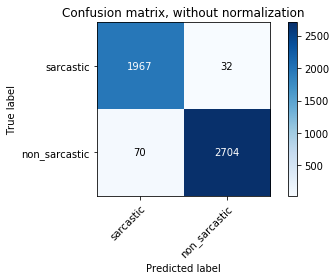

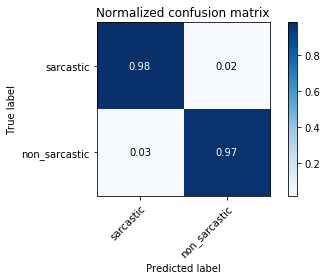

In [45]:
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=False)
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=True)

## checking to see if its overfitting, testing on training data

In [41]:
predictions = svm.predict(training_data)

c_accuracy = accuracy_score(y_train, predictions)
c_recall = recall_score(y_train, predictions, average = 'weighted')
c_precision = precision_score(y_train, predictions, average = 'weighted')
c_f1 = f1_score(y_train, predictions, average = 'weighted')



print("Accuracy score: ", c_accuracy)
print("Recall score: ",c_recall)
print("Precision score: ", c_precision)
print("F1 score: ", c_f1)

Accuracy score:  0.9867290633512608
Recall score:  0.9867290633512608
Precision score:  0.9867516877610962
F1 score:  0.9867346504715984


## doesnt seem like it, score is very high but should be 100% if it was overfitting

In [26]:
svm = SVC()

svm.fit(training_data, y_train)
y_pred = svm.predict(testing_data)

svm_accuracy = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred, average = 'weighted')
svm_precision = precision_score(y_test, y_pred, average = 'weighted')
svm_f1 = f1_score(y_test, y_pred, average = 'weighted')


print("Accuracy score: ", svm_accuracy)
print("Recall score: ",svm_recall)
print("Precision score: ", svm_precision)
print("F1 score: ", svm_f1)
 ## support vector and c'''

/home/guillaume/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



Accuracy score:  0.826314686779803
Recall score:  0.826314686779803
Precision score:  0.8660070285275914
F1 score:  0.8149317404976983


## 3rd set of experiments. Article content + headlines. Probably add all the above experiments to this one too 

In [118]:
### content and headlines ### 

counter = 0
non_empty_articles_y = []
non_empty_article_content = []
non_empty_article_headline = []
for index, row in data_frame.iterrows():
    if row['article_link'] == data_article_content[str(counter)]['link']:
        non_empty_articles_y.append(row['is_sarcastic'])
        non_empty_article_content.append(data_article_content[str(counter)]['content'])
        non_empty_article_headline.append(row['headline'])
        counter += 1
        
new_data_frame = pd.DataFrame()
new_data_frame['article_content'] = non_empty_article_content
new_data_frame['headline'] = non_empty_article_headline
new_data_frame['labels'] = non_empty_articles_y

new_data_frame.head()


,article_content,headline,labels
0,Vegetables don't have to be boring or relegate...,eat your veggies: 9 deliciously different recipes,0
1,"PROVIDENCE, RI—In spite of his best efforts to...",inclement weather prevents liar from getting t...,1
2,"PATERSON, NJ—Family sources told reporters Tue...",mother comes pretty close to using word 'strea...,1
3,To what extent do you own your inheritance?\n\...,my white inheritance,0
4,"Even with years of experience, the process of ...",5 ways to file your taxes with less stress,0


In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    new_data_frame['article_content'] + new_data_frame['headline'], 
    new_data_frame['labels'],
    random_state = 1
)

count_vector = CountVectorizer(stop_words = 'english')
training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)
predictions

array([0, 0, 0, ..., 1, 0, 1])

Confusion matrix, without normalization
[[1826  173]
 [ 272 2502]]
Normalized confusion matrix
[[0.91345673 0.08654327]
 [0.09805335 0.90194665]]


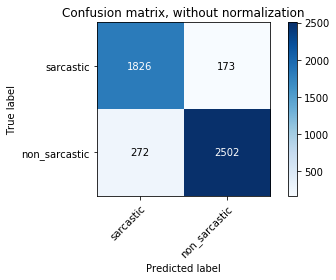

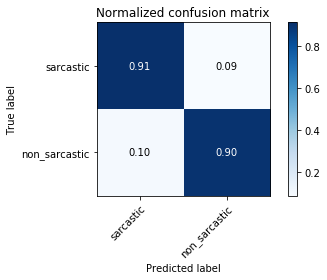

In [120]:
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=False)
plot_confusion_matrix(y_test, predictions, ['sarcastic', 'non_sarcastic'], normalize=True)

In [121]:

hc_accuracy = accuracy_score(y_test, predictions)
hc_recall = recall_score(y_test, predictions, average = 'weighted')
hc_precision =  precision_score(y_test, predictions, average = 'weighted')
hc_f1 = f1_score(y_test, predictions, average = 'weighted') 


print("Accuracy score: ", hc_accuracy)
print("Recall score: ",hc_recall)
print("Precision score: ", hc_precision)
print("F1 score: ", hc_f1)

Accuracy score:  0.9067672323486277
Recall score:  0.9067672323486277
Precision score:  0.9081149097437927
F1 score:  0.9070467232635095


## Bar chart comparing methods used, could probably use this at the end to compare every model we built 

In [122]:
scores = ['Accuracy', 'Recall', 'Precision', 'F1']

headline_scores = [h_accuracy, h_recall, h_precision, h_f1]
content_scores = [c_accuracy, c_recall, c_precision, c_f1]
hc_scores = [hc_accuracy, hc_recall, hc_precision, hc_f1]

fig = go.Figure(data=[
    go.Bar(name='Headline', x=scores, y=headline_scores, text=headline_scores, textposition='auto', ),
    go.Bar(name='Content', x=scores, y=content_scores, text=content_scores, textposition='auto',),
    go.Bar(name='Headline and Content', x=scores, y=hc_scores, text=hc_scores, textposition='auto',)
])

fig.update_layout(barmode='group', title_text="Multinomial NB Classification Results")
fig.show()

### might look at trimming some decimal points ###

NameError: name 'h_accuracy' is not defined